In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import numpy as np
from sklearn import tree, preprocessing
import pickle

data = pd.read_csv ('D:/NLP_Data/Data4Test.csv', encoding='ISO-8859-1')

0    93
1    57
Name: Label, dtype: int64


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

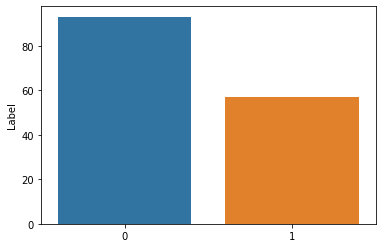

In [2]:
#Check the ratio of desired response[1] to undesired responses[0]

x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [3]:
#Function to make sure the responses labelled [0] those labelled [1] are ballanced
#Function to balance the class
#Arguments => data, catColum -> name of column of the scores i.e. label
# cat_high -> the category of score that is higher i.e. [0]
# cat_low -> the category of score that is lower i.e. [1]
#Ballancing technique is -> downsampling (disadvantage is that we will loose some of our training data)

def balanceClassCategory (data, catColumn, cat_high, cat_low):
    #shuffled = df.sample(frac=1).reset_index()
    df = data.sample(frac=1).reset_index()
    df_cat_high= df[df['Label']== cat_high]
    df_cat_low = df[df['Label']== cat_low]
    df_cat_high_downsampled = df_cat_high.sample(df_cat_low.shape[0])
    df_balanced = pd.concat([df_cat_high_downsampled, df_cat_low])
    
    shuffled = df_balanced.sample(frac=1)
    return shuffled

In [4]:
# balanceClassCategory function on the data
data = balanceClassCategory (data, "Label", 0, 1)

1    57
0    57
Name: Label, dtype: int64


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

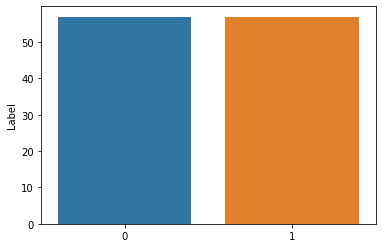

In [5]:
#Visualize the balanced data
x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

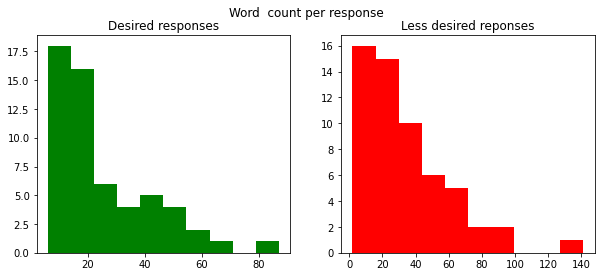

In [6]:
#Vsualize relevant information about our data
#for example here we visualize word-count of responses
#we compare between desired[1] and less-desired[0] responses

data['word_count'] = data['Response'].apply(lambda x: len(str(x).split()))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['Label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Desired responses')
train_words=data[data['Label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Less desired reponses')
fig.suptitle('Word  count per response')
plt.show()

#plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/wordCountPerRespsonseIn_0_1.jpg')

In [7]:
#Preprocess the data to remove punctuations and stop words
#the Brown Corpus text contains specific punctuation sequences 
#( `,and``) that should be removed. You can do that by adding the character sequences 
#to the list of stop words (easier than adding characters to the punctuation module)

nlp = spacy.load("en_core_web_sm")

nlp.Defaults.stop_words.add("`,")
nlp.Defaults.stop_words.add("``")

In [8]:

wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
#Lematizaton that works with string 
#Return string of all the tokens, separated by spaces.
#nltk.download()

def lemmatizeWorkingWithStrings(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    word_pos_tags = nltk.pos_tag(tokens) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return ' '.join(a)

In [10]:
#Remove puctuation and stop words, stem and lemmatize data
data['clean_text'] = data['Response'].apply(lambda x: lemmatizeWorkingWithStrings(x))

In [11]:
#function splits data into X_train, X_test -> [clean_text], y_train, y_test-> [Label] 
#stratify to ensure even distribution of responses labeled [0] or [1] in you train and test data

def splitDataToTrainAndTest(In_data):
    
    X_train, X_test, y_train, y_test = train_test_split(In_data["clean_text"],In_data["Label"],test_size=0.2,shuffle=True,stratify=In_data['Label'])
    
    return  X_train, X_test, y_train, y_test

In [12]:
#model vectorizes the test data
def vectorizeXtrainAndX_test(In_X_train, In_X_test):
   
        
    tfidf_vectorizer = TfidfVectorizer(use_idf=True)
    X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(In_X_train) 
    X_test_vectors_tfidf = tfidf_vectorizer.transform(In_X_test)
    
    return X_train_vectors_tfidf, X_test_vectors_tfidf

In [13]:
def trainAndTest_lr_Model(In_data, runNum):
    
    X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
    lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
    
    lr_tfidf.fit(X_train_vectors_tfidf, y_train)
    
    y_predict = lr_tfidf.predict(X_test_vectors_tfidf)

    y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

    report_lr = classification_report(y_test, y_predict, output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_predict)
    acc = accuracy_score(y_test, y_predict)
    f1= f1_score(y_test, y_predict)
    recall=recall_score(y_test, y_predict)
    
    #print(classification_report(In_y_test, y_predict))
    
    #print('Confusion Matrix:',confusion_matrix(In_y_test, y_predict))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    roc_auc = auc(fpr, tpr)
    listOfX_testValues = X_test.values.tolist()
    rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    raw_X_testData=rawDatabased_on_testData['Response']
    
    nReport = pd.DataFrame(raw_X_testData)
    nReport['clean_text']=X_test
    nReport["Human Label"] = y_test
    nReport["LogisticReg Prediction"] = y_predict
    nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/lr/'+'lr'+str(runNum)+'.csv', index= True)
    
    filename = 'C:/Users/tunji/CMUProject/SavedModels/lrModel'+str(runNum)+'.sav'
    pickle.dump(lr_tfidf, open(filename, 'wb'))
    #print('AUC:', roc_auc)
    #print ("Accuracy", accuracy_score(In_y_test, y_predict))
    #print ("F1-Score", f1_score(In_y_test, y_predict))
    
    #print ("Recall", recall_score(In_y_test, y_predict))
    
    return cm1, acc, f1, recall

In [14]:
def trainAndTest_nb_Model(In_data, runNum):
    
    X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
    nb_tfidf = MultinomialNB()

    nb_tfidf.fit(X_train_vectors_tfidf, y_train)
    
    y_predict = nb_tfidf.predict(X_test_vectors_tfidf)

    y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

    report_lr = classification_report(y_test, y_predict, output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_predict)
    acc = accuracy_score(y_test, y_predict)
    f1= f1_score(y_test, y_predict)
    recall=recall_score(y_test, y_predict)
    
    #print(classification_report(In_y_test, y_predict))
    
    #print('Confusion Matrix:',confusion_matrix(In_y_test, y_predict))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    roc_auc = auc(fpr, tpr)
    listOfX_testValues = X_test.values.tolist()
    rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    raw_X_testData=rawDatabased_on_testData['Response']
    
    nReport = pd.DataFrame(raw_X_testData)
    nReport['clean_text']=X_test
    nReport["Human Label"] = y_test
    nReport["Naive Bayes' Prediction"] = y_predict
    nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/nb/'+'nb'+str(runNum)+'.csv', index= True)
    
    filename = 'C:/Users/tunji/CMUProject/SavedModels/nbModel'+str(runNum)+'.sav'
    pickle.dump(nb_tfidf, open(filename, 'wb'))
    
    #print('AUC:', roc_auc)
    #print ("Accuracy", accuracy_score(In_y_test, y_predict))
    #print ("F1-Score", f1_score(In_y_test, y_predict))
    
    #print ("Recall", recall_score(In_y_test, y_predict))
    
    return cm1, acc, f1, recall

In [15]:
def trainAndTest_SVM_Model(In_data, runsNum):
    
    X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
    SVM = svm.SVC(C=1.0, kernel = 'linear', degree=3, gamma='auto')
    
    SVM.fit(X_train_vectors_tfidf, y_train)

       
    y_predict = SVM.predict(X_test_vectors_tfidf)

    #y_prob = nb_tfidf.predict_proba(In_X_test_vectors_tfidf)[:,1]

    report_nb = classification_report(y_test, y_predict, output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_predict)
    acc = accuracy_score(y_test, y_predict)
    f1= f1_score(y_test, y_predict)
    recall=recall_score(y_test, y_predict)
    
    #print(classification_report(In_y_test, y_predict))
    
    #print('Confusion Matrix:',confusion_matrix(In_y_test, y_predict))
    
    #fpr, tpr, thresholds = roc_curve(In_y_test, y_prob)
    
    #roc_auc = auc(fpr, tpr)
    
    listOfX_testValues = X_test.values.tolist()
    rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    raw_X_testData=rawDatabased_on_testData['Response']
    
    nReport = pd.DataFrame(raw_X_testData)
    nReport['clean_text']=X_test
    nReport["Human Label"] = y_test
    nReport["SVM Prediction"] = y_predict
    nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/svm/'+'SVM'+str(runsNum)+'.csv', index= True)
    
    filename = 'C:/Users/tunji/CMUProject/SavedModels/svmModel'+str(runsNum)+'.sav'
    pickle.dump(SVM, open(filename, 'wb'))
    #print('AUC:', roc_auc)
    #print ("Accuracy", accuracy_score(In_y_test, y_predict))
    #print ("F1-Score", f1_score(In_y_test, y_predict))
    
    #print ("Recall", recall_score(In_y_test, y_predict))
    
    return cm1, acc, f1, recall

In [16]:
def trainAndTest_tree_Model(In_data, runsNum):
    X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
    treeModel = tree.DecisionTreeClassifier()
    treeModel= treeModel.fit(X_train_vectors_tfidf, y_train)
    y_predict = treeModel.predict(X_test_vectors_tfidf)
    
    report_nb = classification_report(y_test, y_predict, output_dict=True)
    
    cm1 = confusion_matrix(y_test, y_predict)
    acc = accuracy_score(y_test, y_predict)
    f1= f1_score(y_test, y_predict)
    recall=recall_score(y_test, y_predict)
    
    listOfX_testValues = X_test.values.tolist()
    rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    raw_X_testData=rawDatabased_on_testData['Response']
    
    nReport = pd.DataFrame(raw_X_testData)
    nReport['clean_text']=X_test
    nReport["Human Label"] = y_test
    nReport["Decission Tree Prediction"] = y_predict
    
    nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/tree/'+'tree'+str(runsNum)+'.csv', index= True)
    
    filename = 'C:/Users/tunji/CMUProject/SavedModels/treeModel'+str(runsNum)+'.sav'
    pickle.dump(treeModel, open(filename, 'wb'))
    
    return cm1, acc, f1, recall
    

In [17]:
def store_model_metricsAND_test_output(accuracyList, f1_ScoreList, recallList, confMatrixData, modelLabel):

    
    filename = 'D:/NLP_SentimentA_RTE_Data/Images/'+modelLabel+'/'+modelLabel+'10Runs.jpg'
    y_acc_points = np.array(accuracyList)
    y_f1_points = np.array(f1_ScoreList)
    y_recal_points = np.array(recallList)
    plt.plot(y_acc_points, color = 'r', label="Accuracy")
    plt.plot(y_f1_points, color = 'b', label="F1 score")
    plt.plot(y_recal_points, color = 'g', label = "Recall")

    plt.xlabel('Number of runs')
    plt.title(modelLabel)
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [18]:
def train_test_Model_AND_Store_Metrics(In_data, runNum, modelFunction, modelLabel):
    
    accList=[]
    f1List = []
    recallList=[]
    cmData = []

    for i in range (runNum):
        cm, acc, f1, recall = modelFunction(In_data, i )
    
        accList.append(acc)
        f1List.append(f1)
        recallList.append(recall)
        cmData.append(cm)
    
    store_model_metricsAND_test_output(accList, f1List, recallList, cmData, modelLabel)
    
    return accList, f1List, recallList, cmData
    

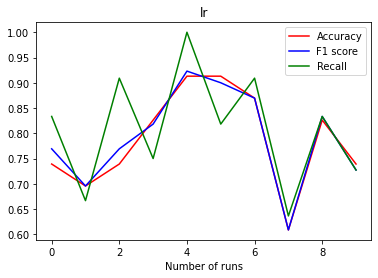

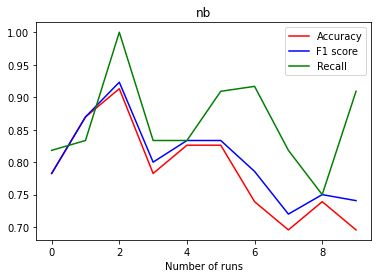

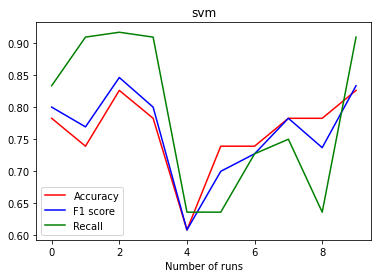

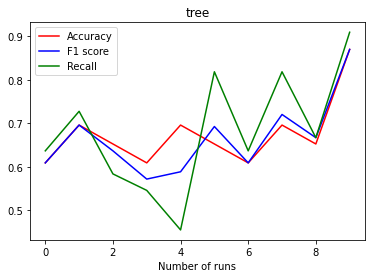

In [19]:
accList_lr, f1List_lr, recallList_lr, cmData_lr=train_test_Model_AND_Store_Metrics(data, 10, trainAndTest_lr_Model, 'lr')
accList_nb, f1List_nb, recallList_nb, cmData_nb=train_test_Model_AND_Store_Metrics(data, 10, trainAndTest_nb_Model, 'nb')
accList_svm, f1List_svm, recallList_svm, cmData_svm=train_test_Model_AND_Store_Metrics(data, 10, trainAndTest_SVM_Model, 'svm')
accList_tree, f1List_tree, recallList_tree, cmData_tree=train_test_Model_AND_Store_Metrics(data, 10, trainAndTest_tree_Model, 'tree')

In [20]:
maxI=accList_tree.index(max(accList_tree))

In [21]:
accList_tree[maxI]

0.8695652173913043

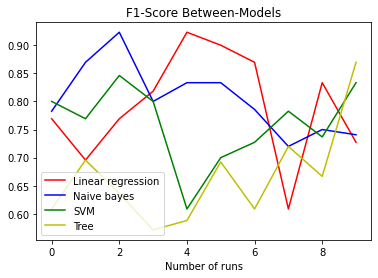

In [22]:
plt.plot(f1List_lr, color = 'r', label="Linear regression")
plt.plot(f1List_nb, color = 'b', label="Naive bayes")
plt.plot(f1List_svm, color = 'g', label = "SVM")
plt.plot(f1List_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('F1-Score Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/f1score_between_models.jpg')
plt.show()

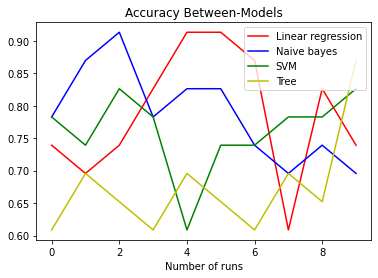

In [23]:
plt.plot(accList_lr, color = 'r', label="Linear regression")
plt.plot(accList_nb, color = 'b', label="Naive bayes")
plt.plot(accList_svm, color = 'g', label = "SVM")
plt.plot(accList_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('Accuracy Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/accuracy_between_models.jpg')
plt.show()

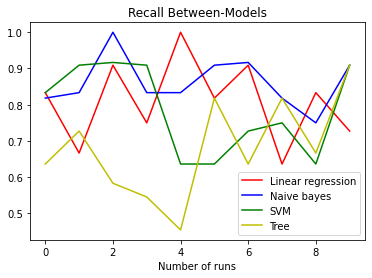

In [24]:
plt.plot(recallList_lr, color = 'r', label="Linear regression")
plt.plot(recallList_nb, color = 'b', label="Naive bayes")
plt.plot(recallList_svm, color = 'g', label = "SVM")
plt.plot(recallList_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('Recall Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/recall_between_models.jpg')
plt.show()

In [25]:
cmData_lr

[array([[ 7,  4],
        [ 2, 10]], dtype=int64),
 array([[8, 3],
        [4, 8]], dtype=int64),
 array([[ 7,  5],
        [ 1, 10]], dtype=int64),
 array([[10,  1],
        [ 3,  9]], dtype=int64),
 array([[ 9,  2],
        [ 0, 12]], dtype=int64),
 array([[12,  0],
        [ 2,  9]], dtype=int64),
 array([[10,  2],
        [ 1, 10]], dtype=int64),
 array([[7, 5],
        [4, 7]], dtype=int64),
 array([[ 9,  2],
        [ 2, 10]], dtype=int64),
 array([[9, 3],
        [3, 8]], dtype=int64)]

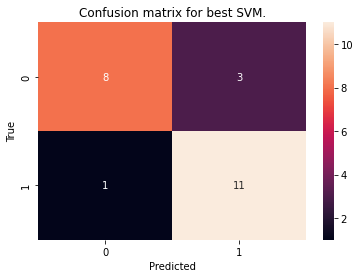

In [26]:
from matplotlib import pyplot as plt
import seaborn as sn
maxAcc_svm=accList_svm.index(max(accList_svm))
cMatrix_svm = cmData_svm[maxAcc_svm]
sn.heatmap(cMatrix_svm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best SVM.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_svm.jpg')



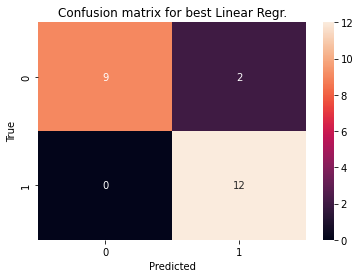

In [27]:
maxAcc_lr=accList_lr.index(max(accList_lr))
cMatrix_lr = cmData_lr[maxAcc_lr]
sn.heatmap(cMatrix_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Linear Regr.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_lr.jpg')



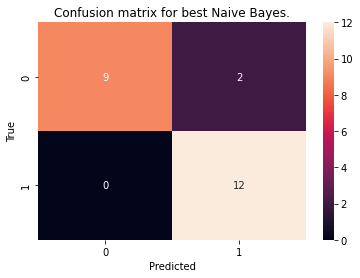

In [28]:
maxAcc_nb=accList_nb.index(max(accList_nb))
cMatrix_nb = cmData_nb[maxAcc_nb]
sn.heatmap(cMatrix_nb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Naive Bayes.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_nb.jpg')



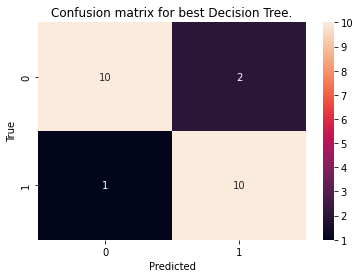

In [29]:
maxAcc_tree=accList_tree.index(max(accList_tree))
cMatrix_tree = cmData_tree[maxAcc_tree]
sn.heatmap(cMatrix_tree, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Decision Tree.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_tree.jpg')

In [38]:
accList_lr.index(max(accList_lr))

4

In [31]:
#save the model to disk



  